In [2]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from white_box.data import (
    chunk_and_tokenize,
    compute_nats_to_bpb_ratio,
    silence_datasets_messages
)
import torch as th

def load_stuff(name, device = 'cuda:0'):
    model = AutoModelForCausalLM.from_pretrained(
        name, torch_dtype="auto"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(name)

    dataset = Dataset.from_json("/mnt/ssd-1/nora/lens-test.jsonl")
    assert isinstance(dataset, Dataset)
    silence_datasets_messages()

    processed = chunk_and_tokenize(dataset, tokenizer)
    ratio = compute_nats_to_bpb_ratio(dataset, processed)
    return model, tokenizer, processed, ratio

model, tokenizer, data, ratio = load_stuff("EleutherAI/pythia-125m")

Using custom data configuration default-17b5822e070b1eaf
Found cached dataset json (/mnt/ssd-1/nora/huggingface/datasets/json/default-17b5822e070b1eaf/0.0.0)


In [3]:
from white_box.nn import Decoder, TunedLens

decoder = Decoder(model)
affine_lens = TunedLens.load("/mnt/ssd-1/nora/real-lenses/pythia/125m/next/").cuda()
mlp_lens = TunedLens.load("/mnt/ssd-1/nora/real-lenses/pythia/125m/mlp/").cuda()

In [4]:
def kl(logit_p, logit_q):
    log_p = logit_p.log_softmax(-1)
    log_q = logit_q.log_softmax(-1)

    return th.sum(log_p.exp() * (log_p - log_q), -1)

In [5]:
def swap_topk(logits: th.Tensor, k: int = 2):
    """Reverse the order of the top-k logits."""
    top_logits, top_indices = logits.topk(k)

    swapped = logits.clone()
    swapped[..., top_indices] = top_logits.flip([-1])
    return swapped


In [17]:
from functools import partial
from tqdm.auto import tqdm, trange
from typing import Callable, Optional
from transformers import PreTrainedModel
from white_box import layer_intervention
from white_box.nn import Decoder, TunedLens
from white_box.utils import pytree_map


@th.autocast('cuda')
@th.no_grad()
def causal_scrub(
    model: PreTrainedModel,
    token_ids: th.Tensor,
    intervention: Callable[[th.Tensor], th.Tensor] = swap_topk,
    lens: Optional[TunedLens] = None,
):
    assert token_ids.ndim == 2
    B, S = token_ids.shape

    # First do a clean forward pass on all the data. We save the
    # logits, as well as the keys and values to speed up inference
    # when we do interventions.
    control = model(token_ids, output_hidden_states=True, use_cache=True)
    decoder = Decoder(model)
    targets = intervention(control.logits)

    # Now compute all the treated hidden states up front.
    pbar = tqdm(control.hidden_states[1:-1], desc="Optimizing hiddens", unit="layer")
    treated_hiddens = []
    for i, h in enumerate(pbar):
        f = partial(lens.transform_hidden, idx=i) if lens is not None else lambda x: x
        result = decoder.invert(
            targets, h0=h, max_iter=5000, tol=th.finfo(h.dtype).eps, transform=f,
        )
        # Make sure the treated hidden has the same norm as the original.
        scale = h.norm(dim=-1) / result.preimage.norm(dim=-1)
        treated_hiddens.append(result.preimage * scale[..., None])

        pbar.set_postfix(kl=result.kl.item())

    L = model.config.num_hidden_layers
    control_kls = kl(targets, control.logits)
    treated_kls = th.zeros(B, S, L - 1, device='cuda')

    for token_idx in trange(1, S, desc="Scrubbing", unit="token"):
        left_ctx = pytree_map(lambda x: x[..., :token_idx, :], control.past_key_values)
        new_tokens = token_ids[:, token_idx, None]

        # Now sequentially intervene on each layer
        for i in range(L - 1):
            with layer_intervention(model, [i], lambda _: treated_hiddens[i][:, token_idx, :]):
                treated = model(
                    new_tokens, output_hidden_states=True, past_key_values=left_ctx
                )

            treated_kls[:, token_idx, i] = kl(targets[:, token_idx], treated.logits.squeeze(1))

    return control_kls, treated_kls

In [7]:
control_affine, treated_affine = causal_scrub(
    model,
    data[:10]['input_ids'][:, :128].cuda(),
    lens=affine_lens
)

Optimizing hiddens:   0%|          | 0/11 [00:00<?, ?layer/s]

Scrubbing:   0%|          | 0/128 [00:00<?, ?token/s]

In [18]:
control_mlp, treated_mlp = causal_scrub(
    model,
    data[:10]['input_ids'][:, :128].cuda(),
    lens=mlp_lens
)

Optimizing hiddens:   0%|          | 0/11 [00:00<?, ?layer/s]

Scrubbing:   0%|          | 0/127 [00:00<?, ?token/s]

In [9]:
control_zero, treated_zero = causal_scrub(
    model,
    data[:10]['input_ids'][:, :128].cuda()
)

Optimizing hiddens:   0%|          | 0/11 [00:00<?, ?layer/s]

Scrubbing:   0%|          | 0/128 [00:00<?, ?token/s]

In [10]:
affine_effects = (control_affine.unsqueeze(-1) - treated_affine) / control_affine.unsqueeze(-1)
mlp_effects = (control_mlp.unsqueeze(-1) - treated_mlp) / control_mlp.unsqueeze(-1)
zero_effects = (control_zero.unsqueeze(-1) - treated_zero) / control_zero.unsqueeze(-1)

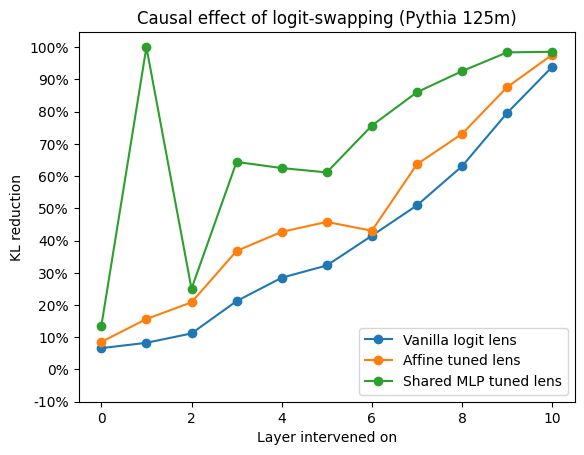

In [30]:
import matplotlib.pyplot as plt
import numpy as np

affine_ate = affine_effects.nanmean((0, 1)).cpu().numpy()
mlp_ate = mlp_effects.nanmean((0, 1)).cpu().numpy()
zero_ate = zero_effects.nanmean((0, 1)).cpu().numpy()

plt.plot(zero_ate, label="Vanilla logit lens", marker='o')
plt.plot(affine_ate, label="Affine tuned lens", marker='o')
plt.plot(mlp_ate, label="Shared MLP tuned lens", marker='o')

plt.title("Causal effect of logit-swapping (Pythia 125m)")
plt.xlabel("Layer intervened on")
plt.ylabel("KL reduction")
plt.yticks(
    ticks=th.linspace(-0.1, 1, 12),
    labels=[f"{x:.0%}" for x in th.linspace(-0.1, 1, 12)]
)
plt.legend()

In [12]:
zero_effects.shape

torch.Size([10, 128, 11])